In [1]:
import networkx as nx
import numpy as np
import torch
from model import Tea
import inference
import pandas as pd
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag
import utils

shuffling = 0
seed = 1
standardize = 0
sample_size = 1000000
batch_size = 100
max_iters = 1000
eval_interval = 100
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cpu'
dropout_rate = 0.0
learning_rate = 5e-3
ff_n_embed = 6
num_heads = 2
n_layers = 1
head_size = 6
d = 1

def generate_data(N, d=3):
    DAGnx = nx.DiGraph()
    
    Ux = np.random.randn(N,d)
    X =  (Ux>0).astype(float)
    
    Ub = np.random.randn(N,d)
    B =  Ub
    
    Uc = np.random.randn(N,d)
    C =  Uc
    
    Uy = np.random.randn(N,d) / 100
    Y = 0.3 * X + 0.0 * B + 0.0 * C +  Uy

    Y0 = 0.3 * 0 + 0.0 * B + 0.0 * C +  Uy
    Y1 =  0.3 * 1 + 0.0 * B + 0.0 * C + Uy

    all_data_dict = {'X': X, 'B': B, 'C': C, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X': 'cont', 'B': 'cont', 'C': 'cont', 'Y': 'cont'}

    DAGnx.add_edges_from([('X', 'Y'), ('B', 'Y'), ('C', 'Y')])
    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
    causal_ordering = get_full_ordering(DAGnx)
    ordered_var_types = dict(sorted(var_types.items(), key=lambda item: causal_ordering[item[0]]))

    return all_data, DAGnx, var_names, causal_ordering, ordered_var_types, Y0, Y1




## Exogenous Example

In [14]:
def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

_, _, _, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  # multi-dim ATE based off a large sample

print(ATE)


for i in range(1):
    all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, d=d)
    indices = np.arange(0, len(all_data))
    np.random.shuffle(indices)
    
    val_inds = indices[:int(validation_fraction*len(indices))]
    train_inds = indices[int(validation_fraction*len(indices)):]
    train_data = all_data[train_inds]
    val_data = all_data[val_inds]
    train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
    input_dim = all_data.shape[2]
    
    model = Tea(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    dag=DAGnx,
                    causal_ordering=causal_ordering,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types,
                    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    all_var_losses = {}
    for iter_ in range(0, max_iters):
        # train and update the model
        model.train()
    
        xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
        xb_mod = torch.clone(xb.detach())
        X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=shuffling)
    
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    
    
        if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
            for key in loss_dict.keys():
                if key not in all_var_losses.keys():
                    all_var_losses[key] = []
                all_var_losses[key].append(loss_dict[key])
    
            model.eval()
            eval_loss = {}
            for split in ['train', 'val']:
                losses = torch.zeros(eval_iters)
                for k in range(eval_iters):
    
                    xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                                   batch_size=batch_size)
                    xb_mod = torch.clone(xb.detach())
                    X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=False)
                    losses[k] = loss.item()
                eval_loss[split] = losses.mean()
            model.train()
            print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")

    model.eval()
    intervention_nodes_vals_0 = {'X': 0}
    intervention_nodes_vals_1 = {'X': 1}
    effect_var = 'Y'
    effect_index = utils.find_element_in_list(var_names, target_string=effect_var)
    
    
    ci = inference.CausalInference(model=model, device=device)
    D0 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_0)
    D1 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_1)
    
    est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean()
    print('ATE:', ATE, 'est ATE:', est_ATE)
    


[0.3]
step 0 of 1000: train_loss 0.0454, val loss 0.0469
step 100 of 1000: train_loss 0.0099, val loss 0.0099
step 200 of 1000: train_loss 0.0047, val loss 0.0048
step 300 of 1000: train_loss 0.0033, val loss 0.0032
step 400 of 1000: train_loss 0.0026, val loss 0.0026
step 500 of 1000: train_loss 0.0021, val loss 0.0021
step 600 of 1000: train_loss 0.0018, val loss 0.0017
step 700 of 1000: train_loss 0.0014, val loss 0.0014
step 800 of 1000: train_loss 0.0011, val loss 0.0011
step 900 of 1000: train_loss 0.0009, val loss 0.0009
ATE: [0.3] est ATE: -0.028528102388143538


In [15]:
model.eval()
preds = model(train_data.to(device))

train_data_1 = train_data.clone()
train_data_0 = train_data.clone()

train_data_1[:, 0, -1] = 1
train_data_0[:, 0, -1] = 0

with torch.no_grad():  # Disable gradient calculation for inference
    preds_1 = model(train_data_1.to(device))
    preds_0 = model(train_data_0.to(device))
    
difference = preds_1[:, effect_index] - preds_0[:, effect_index]

print('est ATE:', difference.mean())

est ATE: tensor(-0.0285)


In [16]:
values_when_1 = preds[train_data[:, 0, -1] == 1, effect_index, -1]

# Extract the values where preds[:, 0, -1] == 0
values_when_0 = preds[train_data[:, 0, -1] == 0, effect_index, -1]

mean_when_1 = torch.mean(values_when_1)
mean_when_0 = torch.mean(values_when_0)
print('est ATE:', mean_when_1 - mean_when_0)

est ATE: tensor(0.2803, grad_fn=<SubBackward0>)


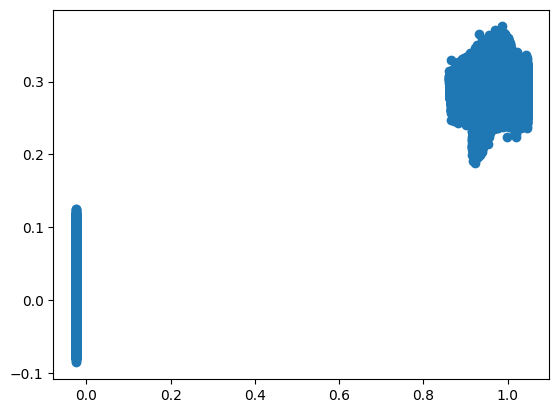

In [18]:
plt.scatter(preds[:,0,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())